# Probing BERT models with part-of-speech tagging 

This tutorial explores how much of part-of-speech tagging is learned by BERT models (transformers pre-trained with language modeling tasks on large quantities of texts).

Part-of-speech (POS) tagging is a natural language processing task which consists in labelling words in context with their grammatical category, such as noun, verb, preposition... The standard benchmark for this task is the universal dependency treebank, a corpus of texts in various languages annotated with syntactic trees in the dependency frame, morphological features and word-level part of speech tags. We are interested in the English section of this corpus which was created from the English Web Treebank (about 16k sentences and 340k words). The dataset is described in details here: https://universaldependencies.org/treebanks/en_ewt/index.html.

We will download three files: the training set, the validation set and the test set. Each file is stored in the CoNLL-U format, a textual format specific to the Universal Dependencies corpora where each line represents a word in a sentence, and columns represent features or labels of that word. In particular, column 2 is the word form, and column 5 is the English-specific POS tags. 

Questions:
* What is the information included in each column of the conll-u format?
* What is the difference between columns 4 and 5?

In [ ]:
import urllib.request

for filename in ['en_ewt-ud-train.conllu', 'en_ewt-ud-dev.conllu', 'en_ewt-ud-test.conllu']:
  urllib.request.urlretrieve('https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/' + filename, filename)

with open('en_ewt-ud-train.conllu') as fp:
  for line in fp.readlines()[:10]:
    print(line, end='')

# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000
# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001
# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
1	Al	Al	PROPN	NNP	Number=Sing	0	root	0:root	SpaceAfter=No
2	-	-	PUNCT	HYPH	_	1	punct	1:punct	SpaceAfter=No
3	Zaman	Zaman	PROPN	NNP	Number=Sing	1	flat	1:flat	_
4	:	:	PUNCT	:	_	1	punct	1:punct	_
5	American	american	ADJ	JJ	Degree=Pos	6	amod	6:amod	_
6	forces	force	NOUN	NNS	Number=Plur	7	nsubj	7:nsubj	_


Reading CoNLL-U files is a bit of work, so we will use the conllu module that can do that for us. Once parsed, a file is presented as a list of sentences, each containing tokens. The tokens are dictionaries with keys associated with the columns for that word. Words and POS can be loaded from the `'form'` and `'xpos'` columns.

Questions:
* How many sentences are there in each subset?


In [ ]:
!pip -q install conllu

import conllu

def load_conllu(filename):
  with open(filename) as fp:
    data = conllu.parse(fp.read())
  sentences = [[token['form'] for token in sentence] for sentence in data]
  taggings = [[token['xpos'] for token in sentence] for sentence in data]
  return sentences, taggings

train_sentences, train_taggings = load_conllu('en_ewt-ud-train.conllu')
valid_sentences, valid_taggings = load_conllu('en_ewt-ud-dev.conllu')
test_sentences, test_taggings = load_conllu('en_ewt-ud-test.conllu')

print(train_sentences[0])
#print(list(zip(train_sentences[42], train_taggings[42])))

['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.']


In [ ]:
print(list(zip(train_sentences[182], train_taggings[182])))

[('Gore', 'NNP'), ('released', 'VBD'), ('a', 'DT'), ('statement', 'NN'), ('Friday', 'NNP'), ('taking', 'VBG'), ('Bush', 'NNP'), ('to', 'IN'), ('task', 'NN'), ('for', 'IN'), ('his', 'PRP$'), ('comments', 'NNS'), ('on', 'IN'), ('Pakistan', 'NNP'), ("'s", 'POS'), ('recent', 'JJ'), ('coup', 'NN'), ('.', '.')]


The meaning of the tags is briefly described in https://www.sketchengine.eu/tagsets/penn-treebank-tagset/. If you compute a few statistics you will see that nouns, prepositions and determiners are the most frequent tags.

Questions:
* What is the meaning of DT?
* What is the meaning of FW?
* What tags are associated with word "move"?
* What words can be tagged as IN?

In [ ]:
# use a defaultdict to count the number of occurrences of each tag
import collections
tagset = collections.defaultdict(int)

for tagging in train_taggings:
  for tag in tagging:
    tagset[tag] += 1

print('number of different tags:', len(tagset))

# print count and tag sorted by decreasing count
for tag, count in sorted(tagset.items(), reverse=True, key=lambda x: x[1]):
  print(count, tag)

number of different tags: 50
26923 NN
20718 IN
16818 DT
12448 NNP
12195 PRP
11575 JJ
10830 RB
10317 .
9476 VB
8446 NNS
8062 ,
6709 CC
5403 VBD
5374 VBP
4580 VBZ
3995 CD
3968 VBN
3329 VBG
3294 MD
3286 TO
3065 PRP$
1007 -RRB-
973 -LRB-
948 WDT
869 WRB
866 :
813 ``
785 ''
760 WP
755 RP
690 UH
684 POS
664 HYPH
502 JJR
498 NNPS
383 JJS
364 EX
338 NFP
294 GW
292 ADD
276 RBR
258 $
175 PDT
169 RBS
161 SYM
117 LS
93 FW
48 AFX
15 WP$
1 XX


You can also look at the distribution of sentence length, which will be important when processing the corpus with a model that crunches whole sentences. That distribution is highly skewed towards short sentences, with very few long sentences. It will not be a problem here, but might become one when working with large datasets and large models.

Questions:
* What is the average sentence length?
* Print the longest sentence.

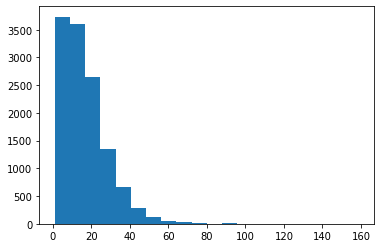

max length: 159


In [ ]:
from matplotlib import pyplot as plt

# compute and show histogram for sentence length
plt.hist([len(sentence) for sentence in train_sentences], 20)
plt.show()

# compute max sentence length
print('max length:', max([len(sentence) for sentence in train_sentences]))

A Pytorch implementation of the BERT model will be provided by the `transformers` package (see https://github.com/huggingface/transformers). It comes with pretrained models for a range of variants of the BERT architecture and trained on different datasets. The list can be found at https://huggingface.co/transformers/pretrained_models.html. 

In [ ]:
# install transformers package
!pip -q install transformers

# import relevant classes for pretrained tokenizer and model
from transformers import AutoTokenizer, AutoModel

     |████████████████████████████████| 890kB 7.4MB/s 
     |████████████████████████████████| 890kB 23.0MB/s 
     |████████████████████████████████| 1.1MB 39.5MB/s 
     |████████████████████████████████| 3.0MB 41.0MB/s 


Tokenization is a tricky part of natural language processing. It aims at chopping the stream of characters at word boundaries, which while looking straightforward, can be a bit tricky. Of course, different tools / corpora will assume different tokenization rules.

The UD tokenization cuts the character stream at spaces, punctuation and uses some special rules, for instance \"can't\" is split as \"can n't\". Such tokenization results in an unbounded number of different words when corpus size gets larger. This problem is exhacerbated for languages with a very productive morphology such as Finnish.

The tokenization for BERT models works differently, in particular because the model is trained to predict tokens which would result in prohibitively large model size with UD tokenization. Instead these types of models perform a tokenization in subword units. Frequent words are tokenized normally, but infrequent words are split in smaller factors which often correspond to affixes. In addition, punctuation is split at the character level. This way, the number of different tokens is kept low (arount 40k for BERT) while preserving linguistic information.

Here is the result of tokenization for a simple sentence. Note how word pieces are prefixed with `'##'`.

Questions:
* Create a sentence which contains at least 5 partial word pieces (starting in ##).

In [ ]:
# load tokenizer for a specific bert model (bert-base-cased)
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# tokenize an example sentence
tokenizer.tokenize('This tokenizer is sooooo awesome.')

['This', 'token', '##izer', 'is', 'so', '##oo', '##oo', 'awesome', '.']

BERT will deliver representation vectors at the token level, so if we want to probe them with the tagging task, we need to align the two different tokenizations. Hopefully, the BERT tokenization is a sub-tokenization of the UD tokenization, so a token on the UD side will be composed of one to many subtokens on the BERT side, but not the converse. For example, the token `sooooo` for UD is split as `so #oo #oo` by BERT.

How can multiple representation vectors generated by BERT for a word be used to predict a single tag (such as `so #oo #oo => RB`)? We choose to align the tag with the last subtoken of the word and convert the rest to the prediction of a special `<pad>` tag. The `<pad>` tag will have an other role when batching sentences together and we will ignore it when evaluating the accuracy of the predicted tags. Other approaches have been proposed such as using the representation of the first subtoken, or averaging the representation vectors of the subtokens. So for the `sooooo => RB` example, the prediction problem becomes `so => <pad>`, `#oo => <pad>`, `#oo => RB`. 

Questions:
* What is the difference in average length between original sentences and tokenized sentences?
* How many `<pad>` tokens are added to the aligned taggings?

In [ ]:
import re

def align_tokenizations(sentences, taggings):
  bert_tokenized_sentences = []
  aligned_taggings = []

  for sentence, tagging in zip(sentences, taggings):
    # first generate BERT-tokenization
    bert_tokenized_sentence = tokenizer.tokenize(' '.join(sentence))

    aligned_tagging = []
    current_word = ''
    index = 0 # index of current word in sentence and tagging
    for token in bert_tokenized_sentence:
      current_word += re.sub(r'^##', '', token) # recompose word with subtoken
      sentence[index] = sentence[index].replace('\xad', '') # fix bug in data

      # note that some word factors correspond to unknown words in BERT
      assert token == '[UNK]' or sentence[index].startswith(current_word)

      if token == '[UNK]' or sentence[index] == current_word: # if we completed a word
        current_word = ''
        aligned_tagging.append(tagging[index])
        index += 1
      else: # otherwise insert padding
        aligned_tagging.append('<pad>')

    assert len(bert_tokenized_sentence) == len(aligned_tagging)

    bert_tokenized_sentences.append(bert_tokenized_sentence)
    aligned_taggings.append(aligned_tagging)

  return bert_tokenized_sentences, aligned_taggings

train_bert_tokenized_sentences, train_aligned_taggings = align_tokenizations(train_sentences, train_taggings)
valid_bert_tokenized_sentences, valid_aligned_taggings = align_tokenizations(valid_sentences, valid_taggings)
test_bert_tokenized_sentences, test_aligned_taggings = align_tokenizations(test_sentences, test_taggings)

print(train_bert_tokenized_sentences[42])
print(train_aligned_taggings[42])

['There', 'has', 'been', 'talk', 'that', 'the', 'night', 'cu', '##rf', '##ew', 'might', 'be', 'implemented', 'again', '.']
['EX', 'VBZ', 'VBN', 'NN', 'IN', 'DT', 'NN', '<pad>', '<pad>', 'NN', 'MD', 'VB', 'VBN', 'RB', '.']


The next stage consists in converting tokens and tags to ids so that they can be crunched by the neural networks. For BERT tokens, the tokenizer comes with its own mapping from tokens to integers. For tags, we will create a dictionnary that assigns each tag to an integer starting from 0 which we use for the special `<pad>` tag.

An additional step is specific to BERT, it consists in prefixing the text with `[CLS]` and postfixing it with `[SEP]`. They tell the model where the sentence starts ane where it ends because it is trained on full documents.

Note that we also convert lists of ids to pytorch tensors at that step. The tensors are sent to GPU prior to returning. There is limited memory on the GPU (about 10G) and for large datasets especially containing images, it is better to send the data to the GPU only once instances have been batched together (see the `collate_fn` function bellow). 

Questions:
* What is the identifier, according to BERT's tokenizer, for word "food"?

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

import collections

label_vocab = collections.defaultdict(lambda: len(label_vocab))
label_vocab['<pad>'] = 0

def convert_to_ids(sentences, taggings):
  sentences_ids = []
  taggings_ids = []
  for sentence, tagging in zip(sentences, taggings):
    sentence_tensor = torch.tensor(tokenizer.convert_tokens_to_ids(['[CLS]'] + sentence + ['SEP'])).long()
    tagging_tensor = torch.tensor([0] + [label_vocab[tag] for tag in tagging] + [0]).long()

    sentences_ids.append(sentence_tensor.to(device))
    taggings_ids.append(tagging_tensor.to(device))
  return sentences_ids, taggings_ids

train_sentences_ids, train_taggings_ids = convert_to_ids(train_bert_tokenized_sentences, train_aligned_taggings)
valid_sentences_ids, valid_taggings_ids = convert_to_ids(valid_bert_tokenized_sentences, valid_aligned_taggings)
test_sentences_ids, test_taggings_ids = convert_to_ids(test_bert_tokenized_sentences, test_aligned_taggings)

print(train_sentences_ids[42])
print(train_taggings_ids[42])
print('num labels:', len(label_vocab))

tensor([  101,  1247,  1144,  1151,  2037,  1115,  1103,  1480, 16408, 11931,
         5773,  1547,  1129,  7042,  1254,   119,   100], device='cuda:0')
tensor([ 0, 29, 22, 19,  9, 10,  8,  9,  0,  0,  9, 13, 14, 19, 23, 11,  0],
       device='cuda:0')
num labels: 51


Torch batching is much easier if data is presented through the Dataset class. As per the [documentation](https://pytorch.org/docs/stable/data.html), our class implements `__getitem__` which returns a pair of sentence and corresponding tagging, and `__len__` which returns the number of instances in the dataset. 

In [ ]:
from torch.utils.data import Dataset

class PosTaggingDataset(Dataset):
  def __init__(self, sentences, taggings):
    assert len(sentences) == len(taggings)
    self.sentences = sentences
    self.taggings = taggings

  def __getitem__(self, i):
    return self.sentences[i], self.taggings[i]

  def __len__(self):
    return len(self.sentences)

Now, we need a function to create a batch from a list of instances. Each instance is a pair of same-sized tensors containing token ids and tag ids. We must return two tensors, one with all sentences, and one with all taggings. Since sentences can be of different length, we will pad them to the longest sentence in the batch. Conveniently, the padding token for BERT and our tagging has id 0, so we can create zero tensors and fill them with data.

In [ ]:
def collate_fn(items):
  max_len = max(len(item[0]) for item in items)

  sentences = torch.zeros((len(items), max_len), device=items[0][0].device).long().to(device)
  taggings = torch.zeros((len(items), max_len)).long().to(device)

  for i, (sentence, tagging) in enumerate(items):
    sentences[i][0:len(sentence)] = sentence
    taggings[i][0:len(tagging)] = tagging

  return sentences, taggings


x, y = collate_fn([[torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6])], [torch.tensor([1, 2]), torch.tensor([3, 4])]])
print(x.shape, y.shape)

torch.Size([2, 3]) torch.Size([2, 3])


The torch `DataLoader` class handles batching and shuffling instances from a torch `Dataset`. We create one for each subset and only shuffle the training set. A larger `batch_size` leads to faster processing at from parallelization at the cost of higher memory usage, but it also acts as regularization, making convergence slower.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(PosTaggingDataset(train_sentences_ids, train_taggings_ids), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(PosTaggingDataset(valid_sentences_ids, valid_taggings_ids), batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(PosTaggingDataset(test_sentences_ids, test_taggings_ids), batch_size=batch_size, collate_fn=collate_fn)

For the sake of comparison, let's start with training a fully supervised classifier from the data. This classifier will be a simple RNN with an embedding layer which projects token ids in a vector space, a bidirectional GRU as recurrent layer, and a decision layer which projects hidden representations from the RNN to the space of POS tags. The model uses [GELU](https://arxiv.org/abs/1606.08415) non linearity and a dropout of 30\%.

Don't expect good performance from this model. It is very simple and POS tagging is known for two difficulties that it cannot handle well, ambiguity and generalization. In order to get state-of-the-art performance (about 97\% accuracy on this dataset), the model would need to account for character sequences (to learn relevant morphemes for classifying words not seen in training), and a label sequence model such as conditional random fields.

Questions:
* Create a batch containing the first 10 sentences of the validation corpus and pass them to the model. What is the shape of the returned sensor?
* What would change in the model if the GRU was not bidirectional?

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
  def __init__(self, num_labels, embed_size=128, hidden_size=128):
    super().__init__()
    self.embedding = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
    self.decision = nn.Linear(1 * 2 * hidden_size, num_labels) # size output by GRU is number of layers * number of directions * hidden size
    self.to(device)
  
  def forward(self, sentences):
    embed_rep = self.embedding(sentences)
    word_rep, sentence_rep = self.rnn(embed_rep)
    return self.decision(F.dropout(F.gelu(word_rep), 0.3))

# check that model works on an arbitrary batch that contains two sentences of length 3
rnn_model = RNNClassifier(len(label_vocab))
with torch.no_grad():
  y = rnn_model(torch.tensor([[0, 1, 2], [3, 4, 5]]).to(device))

# the expected shape is (batch size, max sentence length, number of labels)
print(y.shape)

torch.Size([2, 3, 51])


The following function computes the performance of a model for a given data loader. It returns two values: average batch-level loss, and token-level accuracy. For that, it needs to compute inference on all instances of the dataset provded by the loader. The main loop to perform inference looks like this:

```
for x, y in loader:
  y_scores = model(x)
  loss = criterion(y_scores, y)
```

`x` and `y` are tensors containing sentences and corresponding tags for a batch (as provided by `collate_fn`). `model(x)` calls `model.forward(x)` and returns a tensor of shape (batch-size, sequence-length, num-labels) with scores, also called loggits because they haven't yet been through the softmax which is computed by the criterion, for each possible tag for each word in the sequence for each sequence in the batch. `criterion(y_scores, y)` computes the loss between the predictions represented by `y_scores` and the reference in `y`.

While the average loss is easy to compute, more care is taken for accuracy. First, we compute the argmax of `y_scores` to get the highest scoring tag for each prediction. Then we create a mask with non-zero entries of `y`. This can be used to ignore `<pad>` in computations.

Questions:
* What is accuracy of the model on the test set?
* What is the expected accuracy of a random model given the number of different tags?

In [ ]:
def perf(model, loader):
  criterion = nn.CrossEntropyLoss()
  model.eval() # do not apply training-specific steps such as dropout
  total_loss = correct = num_loss = num_perf = 0
  for x, y in loader:
    with torch.no_grad(): # no need to store computation graph for gradients
      # perform inference and compute loss
      y_scores = model(x)
      loss = criterion(y_scores.view(-1, len(label_vocab)), y.view(-1)) # requires tensors of shape (num-instances, num-labels) and (num-instances)

      # gather loss statistics
      total_loss += loss.item()
      num_loss += 1

      # gather accuracy statistics
      y_pred = torch.max(y_scores, 2)[1] # compute highest-scoring tag
      mask = (y != 0) # ignore <pad> tags
      correct += torch.sum((y_pred == y) * mask) # compute number of correct predictions
      num_perf += torch.sum(mask).item()
  return total_loss / num_loss, correct.item() / num_perf

# without training, accuracy should be a bit less than 2% (chance of getting a label correct)
perf(rnn_model, valid_loader)

(3.8916915878653526, 0.03785288270377734)

Training is very similar to evaluation as it also performs inference. In addition it uses an optimizer which modifies the parameters of the neural network to minimize the `criterion` thanks to the gradients accumulated through the forward pass of the model. At each epoch, we perform inference, modify model weights after each batch, and finally use `perf` to compute loss and accuracy on the validatin data.

Note that training is successful when the training loss gets lower after every epoch. It might fluctuate on validation data because of overtraining or generalization noise.

In [ ]:
import torch.optim as optim

def fit(model, epochs):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-2)
  for epoch in range(epochs):
    model.train()
    total_loss = num = 0
    for x, y in train_loader:
      optimizer.zero_grad() # start accumulating gradients
      y_scores = model(x)
      loss = criterion(y_scores.view(-1, len(label_vocab)), y.view(-1))
      loss.backward() # compute gradients though computation graph
      optimizer.step() # modify model parameters
      total_loss += loss.item()
      num += 1
    print(1 + epoch, total_loss / num, *perf(model, valid_loader))


Let's train the rnn classifier. It is fully supervised, so accuracy should rise quickly. Due to factors already mentionned, it is probably not going to reach state-of-the-art accuracy, but something good enough given the effort we put in the model and surely better than chance. Running more epochs with a learning rate schedule might give a more accurate model but it will not severly improve just by tuning the learning setup.

Questions:
* What happens if you train the model for 10 epochs? 

In [ ]:
rnn_model = RNNClassifier(len(label_vocab))
fit(rnn_model, 5)

1 0.306389457660214 0.140928921289742 0.834910536779324
2 0.0908740681158949 0.11043157370295376 0.8741948310139165
3 0.05610049066456909 0.10764240776188672 0.8817892644135189
4 0.04206655440585954 0.11061940481886268 0.8841749502982107
5 0.0353463868353972 0.11211540910881013 0.8899005964214711


We will now explore how BERT performs at the same POS tagging task except that BERT was not trained explicitly to do it. The principle consists in training a linear model on top of representation vectors generated by BERT for each token. It is important that although we will run BERT inference, we will not touch BERT parameters and only train the linear model.

Before starting, we will define a baseline which inputs random vectors, of the same size as those generated by BERT, to the linear classifier. So if a word is always labelled with the same POS tag, or if a tag has a particularly high prior, the linear model should be able to learn it. We will call this baseline `LinearProbeRandom`. Another popular baseline consists in generating an alternate tagging task with the same number of labels but with all occurences of a given word associated with a single random label. It helps understanding how the model exploits word identities but is also more involved to implement.

The `LinearProbeRandom` consists of an embedding layer which projects words to vectors of size 768 (same as BERT) and a linear model which predicts POS tags from those vectors. The embedding layer is not included in model parameters so that only the probe is trained. Every instanciation of this model will yield a different random embedding. 

In [ ]:
class LinearProbeRandom(nn.Module):
  def __init__(self, num_labels):
    super().__init__()
    self.embedding = nn.Embedding(tokenizer.vocab_size, 768)
    self.probe = nn.Linear(768, num_labels)
    self.to(device)

  def parameters(self):
    return self.probe.parameters()
  
  def forward(self, sentences):
    with torch.no_grad(): # embeddings are not trained
      word_rep = self.embedding(sentences)
    return self.probe(word_rep)

# the model should return a tensor of shape (batch size, sequence length, number of labels)
random_model = LinearProbeRandom(len(label_vocab))
with torch.no_grad():
  y = random_model(torch.tensor([[0, 1, 2], [3, 4, 5]]).to(device))
print(y.shape)

torch.Size([2, 3, 51])


Training the baseline leads to non-trivial performance compared to randomly outputing tags, which means that there is already a lot of regularity in the tag distribution. The question is now whether BERT representations contain more linguistic knowledge directly accessible to a linear classifier.

Question:
* What happens if you train the model for 10 epochs?
* How do you explain the difference in training time betwen the RNN and the probe?

In [ ]:
random_model = LinearProbeRandom(len(label_vocab))
fit(random_model, 5)

1 0.4851789587006277 0.40942691499367356 0.6808349900596421
2 0.3683222181030682 0.3855127966962755 0.6943538767395626
3 0.33951936472131283 0.34710615081712604 0.6848906560636183
4 0.3297648745379886 0.34240866359323263 0.6805566600397615
5 0.32912805486394436 0.3386711673811078 0.6791252485089463


The linear probe for the BERT model follows the exact same architecture than the baseline probe, except that the pretrained BERT model provided by the transformers package is used. Again, we do not train BERT parameters and only use the generated representations. Given enough memory, they could be pre-computed before training the linear probe.

In [ ]:
class LinearProbeBert(nn.Module):
  def __init__(self, num_labels):
    super().__init__()
    self.bert = AutoModel.from_pretrained('bert-base-cased')
    self.probe = nn.Linear(self.bert.config.hidden_size, num_labels)
    self.to(device)

  def parameters(self):
    return self.probe.parameters()
  
  def forward(self, sentences):
    with torch.no_grad(): # no training of BERT parameters
      word_rep, sentence_rep = self.bert(sentences, return_dict=False)
    return self.probe(word_rep)

# the model should return a tensor of shape (batch size, sequence length, number of labels)
bert_model = LinearProbeBert(len(label_vocab))
y = bert_model(torch.tensor([[0, 1, 2], [3, 4, 5]]).to(device))
print(y.shape)


torch.Size([2, 3, 51])


Training the BERT probe is much slower than the baseline probe because BERT representations are recomputed every time a sentence is presented to the model. 

Questions:
* How does accuracy on the development set compare with the random probe?

In [ ]:
bert_model = LinearProbeBert(len(label_vocab))
fit(bert_model, 5)

1 0.24444428475915778 0.09562666842248291 0.8998011928429424
2 0.09677041964415385 0.078243094147183 0.9149105367793241
3 0.08461419627906716 0.07228884345386177 0.9227435387673957
4 0.08005621008650989 0.0706025876570493 0.9218290258449304
5 0.076806691000048 0.06890617276076227 0.9247316103379721


Recap of performance on the test set. The good accuracy of the probe trained on BERT representations suggests that pretraining on large quantities of text with language modeling tasks (masking words, guessing whether two sentences follow eachother) leads to representations that embed some sort of linguistic knowledge. 

It is difficult to compare the performance of the BERT probe to the RNN but others have shown that ELMO, a RNN pre-trained in a similar fashion than BERT exhibit good linguistic probing accuracy, suggesting that the neural network architecture is not as important as the pre-training.

Questions:
* What can you conclude from this set of results?
* What confounding factors might hinder these conclusions?

In [ ]:
print('RNN representation (supervised)', *perf(rnn_model, test_loader))
print('RANDOM representation (unsupervised)', *perf(random_model, test_loader))
print('BERT representation (unsupervised)', *perf(bert_model, test_loader))

RNN representation (supervised) 0.10681300356306812 0.886799219030163
RANDOM representation (unsupervised) 0.327771899262161 0.6761764354305295
BERT representation (unsupervised) 0.06551418730029554 0.915966051719329


Exercise 1
--------
Download and probe GloVe embeddings for the POS tagging task (https://nlp.stanford.edu/projects/glove/).

Exercise 2
-----
Probe the `bert-base-multilingual-cased` model from huggingface for French POS tagging (pageperso.lis-lab.fr/benoit.favre/files/ftb.tgz).

Ideas to go further:
* Implement the alternative baseline probe which replaces the taggings with a random labelling where each word is always assocated with the same label. 
* Train a BERT probe with an untrained BERT model (is there anything to the transformer architecture itself?)
* Fine-tune a BERT model for POS-tagging in the fully supervised setting (use a learning rate of 2e-5, and use a linear warmup [learning rate schedule](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.LambdaLR) on 10% of the updates as suggested by BERT authors)